# Import libraries

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from deepface import DeepFace


## Store paths of videos in dataframes 

In [4]:
truthful_base_dir = 'Videos/Truthful'  # Replace with the actual path to the Videos/Truthful directory
deceptive_base_dir = 'Videos/Deceptive'  # Replace with the actual path to the Videos/Deceptive directory

# List all the files in the directory
truthful_files = os.listdir(truthful_base_dir)
deceptive_files = os.listdir(deceptive_base_dir)

# Filter out the .mp4 files
truthful_video_files = [file for file in truthful_files if file.endswith('.mp4')]
deceptive_video_files = [file for file in deceptive_files if file.endswith('.mp4')]

# One example video path
example_video_path = os.path.join(truthful_base_dir, truthful_video_files[2])

# Join the base directory with the video file name for all the video files
truthful_video_paths = [os.path.join(truthful_base_dir, video_file) for video_file in truthful_video_files]
deceptive_video_paths = [os.path.join(deceptive_base_dir, video_file) for video_file in deceptive_video_files]

truthful_paths_df = pd.DataFrame(columns=['file', 'path'])
truthful_paths_df['file'] = truthful_video_files
truthful_paths_df['path'] = truthful_video_paths
truthful_paths_df.sort_values(by='file', inplace=True)
truthful_paths_df.reset_index(drop=True, inplace=True)
truthful_paths_df["is_deceptive"] = 0

deceptive_paths_df = pd.DataFrame(columns=['file', 'path'])
deceptive_paths_df['file'] = deceptive_video_files
deceptive_paths_df['path'] = deceptive_video_paths
deceptive_paths_df.sort_values(by='file', inplace=True)
deceptive_paths_df.reset_index(drop=True, inplace=True)
deceptive_paths_df["is_deceptive"] = 1

In [5]:
len(truthful_paths_df), len(deceptive_paths_df)


(59, 57)

### Train-Test Split 

In [6]:
# Create random integer indices for the truthful and deceptive videos
np.random.seed(0)
truthful_indices = list(np.random.choice(len(truthful_paths_df), int(len(truthful_paths_df)/5), replace=False))
deceptive_indices = list(np.random.choice(len(deceptive_paths_df), int(len(deceptive_paths_df)/5), replace=False))
len(truthful_indices), len(deceptive_indices)

(11, 11)

In [7]:
test_truthful_paths_df = truthful_paths_df.iloc[truthful_indices].reset_index(drop=True)
test_deceptive_paths_df = deceptive_paths_df.iloc[deceptive_indices].reset_index(drop=True)
train_truthful_paths_df = truthful_paths_df.drop(truthful_indices).reset_index(drop=True) 
train_deceptive_paths_df = deceptive_paths_df.drop(deceptive_indices).reset_index(drop=True)

In [8]:
test_deceptive_paths_df


,file,path,is_deceptive
0,trial_lie_026.mp4,Videos/Deceptive/trial_lie_026.mp4,1
1,trial_lie_031.mp4,Videos/Deceptive/trial_lie_031.mp4,1
2,trial_lie_011.mp4,Videos/Deceptive/trial_lie_011.mp4,1
3,trial_lie_023.mp4,Videos/Deceptive/trial_lie_023.mp4,1
4,trial_lie_055.mp4,Videos/Deceptive/trial_lie_055.mp4,1
5,trial_lie_008.mp4,Videos/Deceptive/trial_lie_008.mp4,1
6,trial_lie_025.mp4,Videos/Deceptive/trial_lie_025.mp4,1
7,trial_lie_003.mp4,Videos/Deceptive/trial_lie_003.mp4,1
8,trial_lie_056.mp4,Videos/Deceptive/trial_lie_056.mp4,1
9,trial_lie_033.mp4,Videos/Deceptive/trial_lie_033.mp4,1


## Divide all videos to 1.5 second parts

In [9]:
from moviepy.editor import VideoFileClip

def split_video(video_path, output_directory, part_duration=1.5):
    video = VideoFileClip(video_path['path'])
    duration = video.duration  # Total duration of the video
    number_of_parts = int(duration / part_duration) # Duration of each part

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for i in range(number_of_parts):
        start_time = i * part_duration
        end_time = start_time + part_duration
        new_clip = video.subclip(start_time, end_time)
        # Construct the output file path
        output_file_path = os.path.join(output_directory, f"{video_path['file'][0:-4]}_part_{i+1}.mp4")
        new_clip.write_videofile(output_file_path, codec='libx264')  # Save the subclip


python(39098) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39099) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [ ]:
for i in range(len(train_truthful_paths_df)):
    split_video(train_truthful_paths_df.iloc[i], 'Train_Divided_Videos/Truthful')

In [ ]:
for i in range(len(train_deceptive_paths_df)):
    split_video(train_deceptive_paths_df.iloc[i], 'Train_Divided_Videos/Deceptive')

In [ ]:
for i in range(len(test_truthful_paths_df)):
    split_video(test_truthful_paths_df.iloc[i], 'Test_Divided_Videos/Truthful')

In [ ]:
for i in range(len(test_deceptive_paths_df)):
    split_video(test_deceptive_paths_df.iloc[i], 'Test_Divided_Videos/Deceptive')

## Obtain 30 frames from each video

In [16]:
def extract_frames(video_path, save_frames=False, base_dir=None):
    # Create a VideoCapture object
    cap = cv2.VideoCapture(video_path["path"])
    
    if not cap.isOpened():
        raise Exception("Error: Unable to open video file.")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate interval to sample 30 frames evenly
    interval = np.linspace(0, total_frames - 1, 30).astype(int)
    
    # Initialize a list to store the frames
    frames = []
    successful_reads = 0
    last_good_frame = None  
    
    # Read and store the evenly spaced frames
    for i in interval:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret and frame is not None and frame.size != 0:
            frames.append(frame)
            successful_reads += 1
            last_good_frame = frame
        else:
            # If a frame read fails, try to get the next frame
            print(f"Warning: Unable to read frame at position {i}. Trying next frame...")
            if ret == False:
                for attempt in range(1, 10):  # Try the next 10 frames
                    if successful_reads >= 30:
                        break
                    cap.set(cv2.CAP_PROP_POS_FRAMES, i + attempt)
                    ret, frame = cap.read()
                    if ret:
                        frames.append(frame)
                        successful_reads += 1
                        break
            if last_good_frame is not None:
                frames.append(last_good_frame)
                successful_reads += 1

        # Break out of the loop if we've collected 30 frames
        if successful_reads >= 30:
            break

    # Copy the last frame to fill the remaining frames
    while successful_reads < 30:
        frames.append(last_good_frame)
        successful_reads += 1
    
    # Release the VideoCapture object
    cap.release()
    
    if save_frames:
        video_name = video_path['file'][0:-4]  # Assuming this extracts the correct video name without file extension
        target_dir = os.path.join(base_dir, video_name)
        os.makedirs(target_dir, exist_ok=True)

        # Save each frame as an image
        for i, frame in enumerate(frames):
            frame_path = os.path.join(target_dir, f"frame_{i}.jpg")
            cv2.imwrite(frame_path, frame)
    
    
    return frames

video_path = truthful_paths_df.iloc[7]
frames = extract_frames(video_path, save_frames=False, base_dir='falan')
print(f"Collected {len(frames)} frames.")


Collected 30 frames.


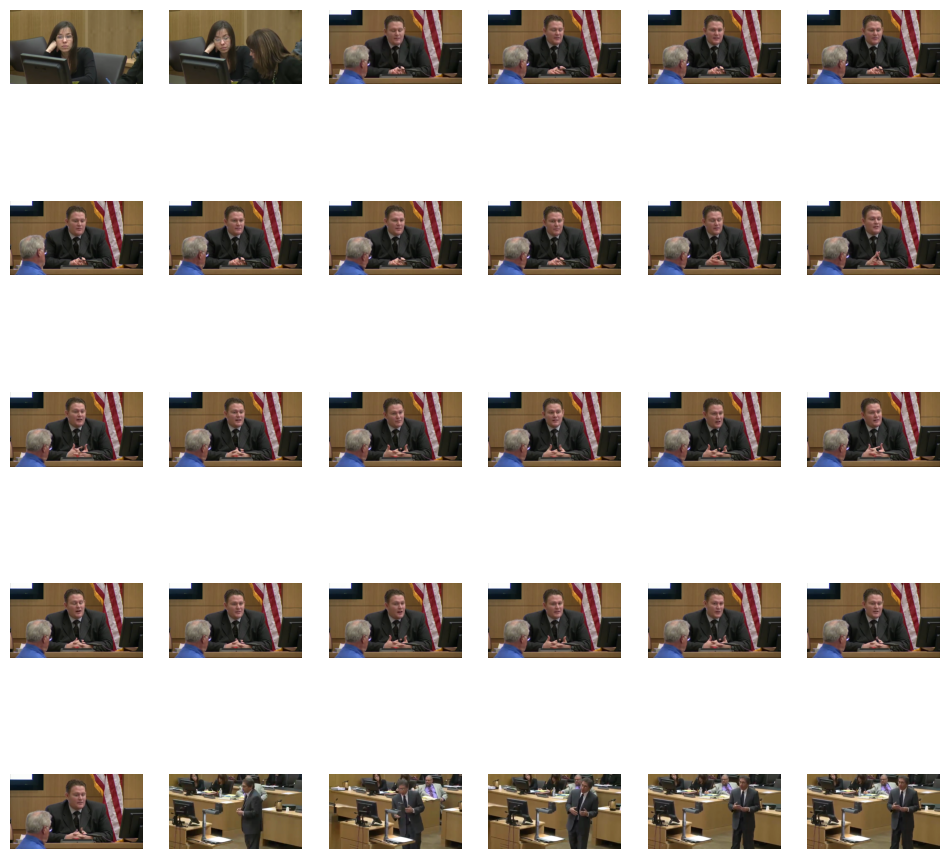

In [17]:
# Display the frames
plt.figure(figsize=(12, 12))
for i, frame in enumerate(frames):
    plt.subplot(5, 6, i + 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [26]:
frame.shape # (height, width, channels) (360, 640, 3)
            # To present it as a training example, we need to reshape it to (1, height, width, channels)
            # If I concat the frames, I will have (n_frames, height, width, channels)
            # If I want to use the concatenated frames as a training example, I need to reshape it to (1, n_frames, height, width, channels)

(360, 640, 3)

## Function which extracts faces from frames

In [18]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
err_counter = 0
resized = []

def extracy_faces(frame, save_frames=False, base_dir=None):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.05, 6, minSize=(100,100))

    try:
        for (x,y,w,h) in faces:
            roi_color = frame[y:y+h, x:x+w] 
            return cv2.resize(roi_color, (128,128))
    except:
        print("No faces detected")
        return None


More Advanced Face Extractor

In [19]:
def extracy_faces(frame, save_frames=False, base_dir=None):
    face_objs = DeepFace.extract_faces(
    img_path = frame, 
    detector_backend = "retinaface",
    enforce_detection=False
    )
    face = max(face_objs, key=lambda x: x['confidence'])['face']
    face = cv2.resize(face, (224,224))
    if face.dtype == 'float64':
        face = (face * 255).astype('uint8')
    return face

In [20]:
#face detection and alignment
face_objs = DeepFace.extract_faces(
  img_path = "IMG_4868.jpeg", 
  detector_backend = "retinaface",
)
face = max(face_objs, key=lambda x: x['confidence'])['face']
face = cv2.resize(face, (224,224))
if face.dtype == 'float64':
        face = (face * 255).astype('uint8')
plt.imshow(face)
face.shape

ValueError: Confirm that IMG_4868.jpeg exists

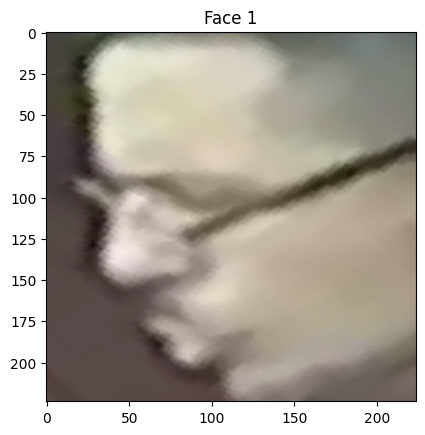

In [61]:
for idx, face_obj in enumerate(face_objs):
    face = face_objs[idx]['face']
    face = cv2.resize(face, (224,224))
    
    # Convert the image to uint8 if it is in float64
    if face.dtype == 'float64':
        face = (face * 255).astype('uint8')
        
    
    # Convert color space from BGR to RGB for displaying
    face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    
    # Display the face
    plt.imshow(face)
    plt.title(f"Face {idx + 1}")
    plt.show()

In [21]:
def extract_frames(video_path, save_frames=False, base_dir=None, extract_faces=False):
    # Create a VideoCapture object
    cap = cv2.VideoCapture(video_path["path"])
    #cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise Exception("Error: Unable to open video file.")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate interval to sample 30 frames evenly
    interval = np.linspace(0, total_frames - 1, 30).astype(int)
    
    # Initialize a list to store the frames
    frames = []
    successful_reads = 0
    last_good_frame = None  
    
    # Read and store the evenly spaced frames
    for i in interval:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret and frame is not None and frame.size != 0:
            frames.append(frame)
            successful_reads += 1
            last_good_frame = frame
        else:
            # If a frame read fails, try to get the next frame
            print(f"Warning: Unable to read frame at position {i}. Trying next frame...")
            if ret == False:
                for attempt in range(1, 10):  # Try the next 10 frames
                    if successful_reads >= 30:
                        break
                    cap.set(cv2.CAP_PROP_POS_FRAMES, i + attempt)
                    ret, frame = cap.read()
                    if ret:
                        frames.append(frame)
                        successful_reads += 1
                        break
            if last_good_frame is not None:
                frames.append(last_good_frame)
                successful_reads += 1

        # Break out of the loop if we've collected 30 frames
        if successful_reads >= 30:
            break

    # Copy the last frame to fill the remaining frames
    while successful_reads < 30:
        frames.append(last_good_frame)
        successful_reads += 1
    # Release the VideoCapture object
    cap.release()
    
    if extract_faces:
        faces = []
        for i, frame in enumerate(frames):
            face = extracy_faces(frame)
            if face is not None:
                faces.append(face)
            else:
                if i == 0:
                    faces.append(np.zeros((224,224,3), np.uint8))
                else:
                    faces.append(faces[-1])
        frames = faces
    
    
    if save_frames:
        video_name = video_path['file'][0:-4]  # Assuming this extracts the correct video name without file extension
        target_dir = os.path.join(base_dir, video_name)
        os.makedirs(target_dir, exist_ok=True)

        # Save each frame as an image
        for i, frame in enumerate(frames):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_path = os.path.join(target_dir, f"frame_{i}.jpg")
            cv2.imwrite(frame_path, frame)
    
    return np.array(frames)

faces = []
video_path = truthful_paths_df.iloc[20]
#faces = extract_frames(video_path, save_frames=False, base_dir=None, extract_faces=True)
#print(f"Collected {len(faces)} frames.")


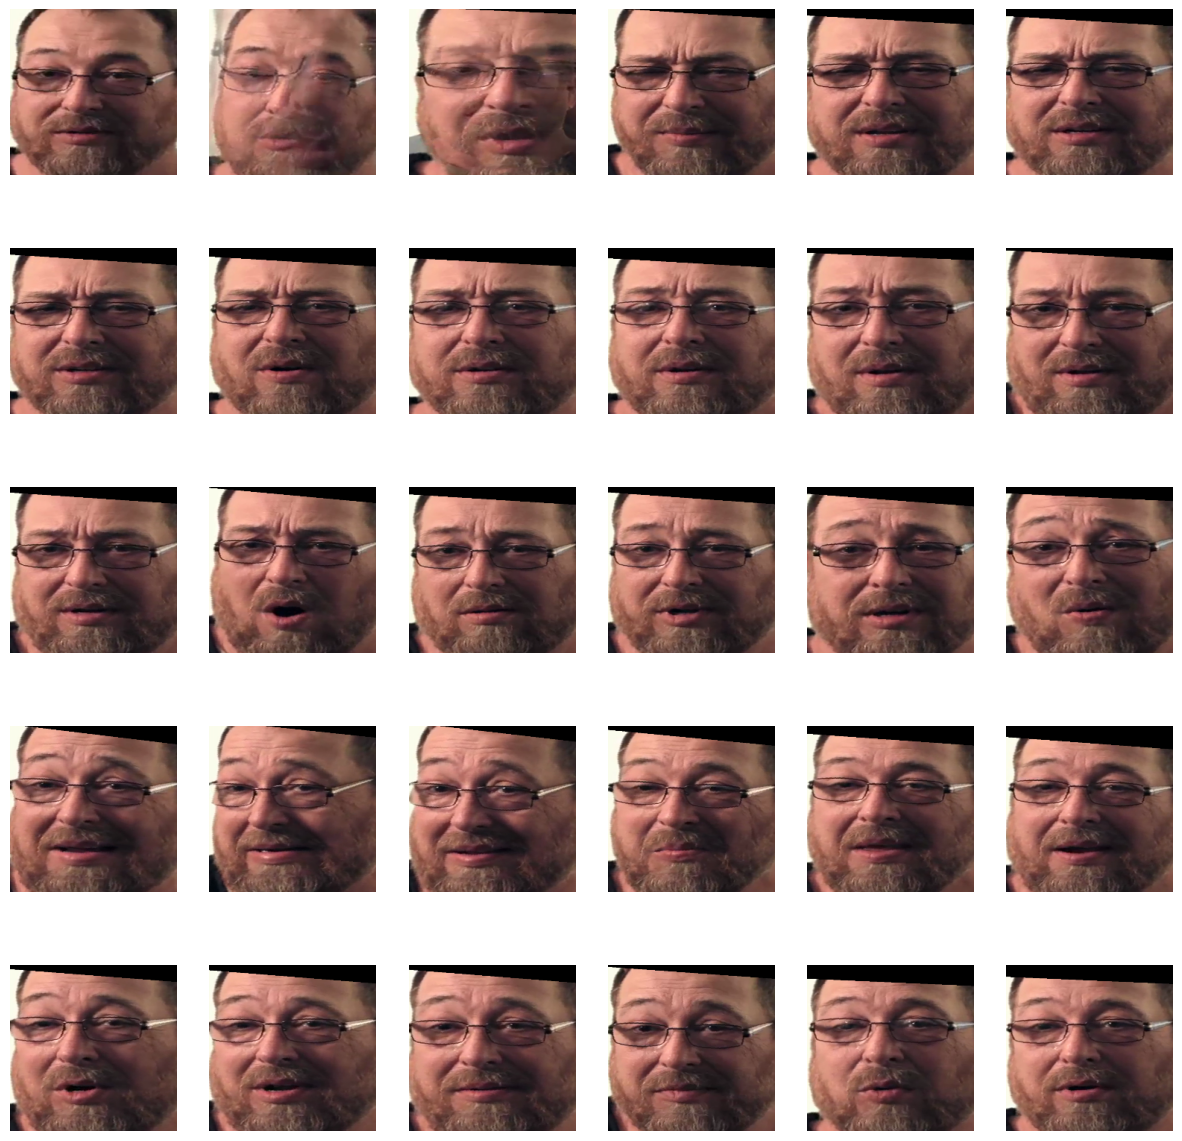

In [117]:
# Show all the frames
plt.figure(figsize=(15, 15))
for i, frame in enumerate(faces):
    if frame.dtype == 'float64':
        frame = (frame * 255).astype('uint8')
    plt.subplot(5, 6, i+1)
    #plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.imshow(frame)
    plt.axis('off')

## Convert all train data to Torch Dataset

In [12]:
truthful_base_dir_divided = 'Test_Divided_Videos/Truthful'  # Replace with the actual path to the Videos/Truthful directory
deceptive_base_dir_divided = 'Test_Divided_Videos/Deceptive'  # Replace with the actual path to the Videos/Deceptive directory

# List all the files in the directory
truthful_files_divided = os.listdir(truthful_base_dir_divided)
deceptive_files_divided = os.listdir(deceptive_base_dir_divided)

# Filter out the .mp4 files
truthful_video_files_divided = [file for file in truthful_files_divided if file.endswith('.mp4')]
deceptive_video_files_divided = [file for file in deceptive_files_divided if file.endswith('.mp4')]

# Join the base directory with the video file name for all the video files
truthful_video_paths_divided = [os.path.join(truthful_base_dir_divided, video_file) for video_file in truthful_video_files_divided]
deceptive_video_paths_divided = [os.path.join(deceptive_base_dir_divided, video_file) for video_file in deceptive_video_files_divided]

truthful_paths_divided_df = pd.DataFrame(columns=['file', 'path'])
truthful_paths_divided_df['file'] = truthful_video_files_divided
truthful_paths_divided_df['path'] = truthful_video_paths_divided
truthful_paths_divided_df.sort_values(by='file', inplace=True)
truthful_paths_divided_df.reset_index(drop=True, inplace=True)

deceptive_paths_divided_df = pd.DataFrame(columns=['file', 'path'])
deceptive_paths_divided_df['file'] = deceptive_video_files_divided
deceptive_paths_divided_df['path'] = deceptive_video_paths_divided
deceptive_paths_divided_df.sort_values(by='file', inplace=True)
deceptive_paths_divided_df.reset_index(drop=True, inplace=True)


In [22]:
deceptive_paths_divided_df
truthful_paths_divided_df

,file,path
0,trial_truth_003_part_1.mp4,Test_Divided_Videos/Truthful/trial_truth_003_p...
1,trial_truth_003_part_2.mp4,Test_Divided_Videos/Truthful/trial_truth_003_p...
2,trial_truth_003_part_3.mp4,Test_Divided_Videos/Truthful/trial_truth_003_p...
3,trial_truth_003_part_4.mp4,Test_Divided_Videos/Truthful/trial_truth_003_p...
4,trial_truth_003_part_5.mp4,Test_Divided_Videos/Truthful/trial_truth_003_p...
...,...,...
193,trial_truth_048_part_5.mp4,Test_Divided_Videos/Truthful/trial_truth_048_p...
194,trial_truth_048_part_6.mp4,Test_Divided_Videos/Truthful/trial_truth_048_p...
195,trial_truth_048_part_7.mp4,Test_Divided_Videos/Truthful/trial_truth_048_p...
196,trial_truth_048_part_8.mp4,Test_Divided_Videos/Truthful/trial_truth_048_p...


In [121]:
extract_frames(video_path, save_frames=True, base_dir="Face_Frames2", extract_faces=True)

array([[[[251, 252, 236],
         [251, 252, 236],
         [251, 252, 236],
         ...,
         [ 76,  73,  63],
         [101,  99,  89],
         [138, 135, 124]],

        [[250, 251, 235],
         [251, 252, 236],
         [251, 252, 236],
         ...,
         [ 68,  66,  55],
         [ 80,  78,  67],
         [102,  99,  87]],

        [[250, 251, 235],
         [251, 252, 236],
         [251, 252, 236],
         ...,
         [ 70,  67,  58],
         [ 72,  69,  60],
         [ 82,  80,  69]],

        ...,

        [[ 45,  23,  23],
         [ 59,  30,  30],
         [ 77,  41,  42],
         ...,
         [111,  69,  61],
         [111,  69,  61],
         [109,  68,  61]],

        [[ 41,  23,  23],
         [ 49,  26,  25],
         [ 66,  37,  37],
         ...,
         [109,  67,  61],
         [108,  67,  61],
         [107,  67,  60]],

        [[ 35,  25,  24],
         [ 40,  26,  26],
         [ 56,  32,  33],
         ...,
         [109,  67,  61],
        

In [23]:
"""video_path = truthful_paths_df.iloc[15]
faces = extract_frames(video_path, save_frames=False, base_dir=None, extract_faces=True)
print(f"Collected {len(faces)} frames.")"""


truthful_data = []
for i, video_path in truthful_paths_divided_df.iterrows():
    faces = extract_frames(video_path, save_frames=True, base_dir="Face_Frames2_Test/Truthful", extract_faces=True)
    truthful_data.append(faces)


In [143]:
np_truthful_data = np.array(truthful_data)
np_truthful_data.shape

(888, 30, 224, 224, 3)

trial_lie_024_part1 den itibaren başlat
deceptive_data listesini baştan oluşturma, üzerine append etmeye devam et.

In [139]:
# Find index of trial_lie_024_part_1.mp4
deceptive_paths_divided_df[deceptive_paths_divided_df['file'] == 'trial_lie_024_part_1.mp4']
deceptive_paths_divided_df = deceptive_paths_divided_df.iloc[336:]

In [24]:
deceptive_data = []
for i, video_path in deceptive_paths_divided_df.iterrows():
    faces = extract_frames(video_path, save_frames=True, base_dir="Face_Frames2_Test/Deceptive", extract_faces=True)
    deceptive_data.append(faces)